In [106]:
import numpy as np
import os
import pandas as pd
import re
import requests
import kagglehub
import sys
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Machine Learning Project

by Andon Gorchov (@thunderman913)

In [2]:
path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\andon\.cache\kagglehub\datasets\tsaustin\us-historical-stock-prices-with-earnings-data\versions\7


In [3]:
earnings_path = f"{path}\\stocks_latest\\earnings_latest.csv"
stock_prices_path = f"{path}\\stocks_latest\\stock_prices_latest.csv"

In [4]:
earnings_data = pd.read_csv(earnings_path)
stock_data = pd.read_csv(stock_prices_path)

In [5]:
# Function to get the price X days ago
def get_price_x_days_ago(df, days):
    return df['close'].shift(days)

# Function to get peak price and how many days ago it happened
def get_peak_price_and_days_ago(df):
    df['peak_price'] = df['close'].rolling(window=90, min_periods=1).max()
    peak_day_index = df['close'].rolling(window=90, min_periods=1).apply(lambda x: (len(x) - 1 - x.argmax()), raw=False)
    df['peak_days_ago'] = peak_day_index.fillna(0).astype(int)  # Fill NaN for rows that don't have enough data
    return df

# Apply the operations without grouping by ticker
def process_ticker_data(df):
    # Add columns for prices X days ago
    for days in [1,2,3,4,5, 10, 15, 30, 60, 90]:
        df[f'price_{days}_days_ago'] = df.groupby('ticker')['close'].shift(days)
        df[f'volume_{days}_days_ago'] = df.groupby('ticker')['volume'].shift(days)
    
    # Get peak price and peak days ago
    #df = df.groupby('ticker', group_keys=False).apply(get_peak_price_and_days_ago)
    return df

In [6]:
def tidyStockData():
    file_path = 'stock_data_processed.pkl'

    # Check if the file exists
    if os.path.exists(file_path):
        return pd.read_pickle('stock_data_processed.pkl')

    stock_data_tidy = stock_data

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'])

    stock_data_tidy = stock_data_tidy[(stock_data_tidy['date'] > (earnings_data_tidy['date'].min() - pd.Timedelta(days=100)))
                                    | (stock_data_tidy['date'] < earnings_data_tidy['date'].max() + pd.Timedelta(days=5))]

    # Sort the DataFrame by ticker and date
    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    # Process the DataFrame without grouping
    stock_data_tidy = process_ticker_data(stock_data_tidy)

    stock_data_tidy = stock_data_tidy[stock_data_tidy.price_90_days_ago.isna() == False]
    stock_data_tidy.to_pickle('stock_data_processed.pkl')
    
    return stock_data_tidy

In [7]:
stock_data_tidy = tidyStockData()

In [8]:
earnings_data_tidy = earnings_data
earnings_data_tidy.date = pd.to_datetime(earnings_data_tidy.date)

In [9]:
earnings_data_tidy = earnings_data_tidy.rename(columns={'symbol': 'ticker'})

In [10]:
earnings_data_tidy = earnings_data_tidy.drop(earnings_data_tidy[(earnings_data_tidy.eps.isna()) | (earnings_data_tidy.eps_est.isna())].index)
earnings_data_tidy = earnings_data_tidy.drop(columns=['qtr'])

In [11]:
earnings_data_tidy = earnings_data_tidy.rename(columns={'date': 'earnings_date'})

In [12]:
earnings_data_tidy['release_time'] = earnings_data_tidy.groupby('ticker')['release_time'].ffill().bfill()

In [13]:
# Adding earnings data to stock_data_tidy based on the nearest previous date
def add_earnings_data(stock_data, earnings):
    # Merge earnings data and stock data on ticker
    merged_df = pd.merge_asof(
        stock_data.sort_values(by='date'),
        earnings.sort_values(by='earnings_date'),
        by='ticker',
        left_on='date',
        right_on='earnings_date',
        direction='backward'
    )
    
    # Forward fill to ensure non-trading days are adjusted properly
    merged_df = merged_df.sort_values(by=['ticker', 'date'])

    # Merge again to get the next earnings date
    merged_df = pd.merge_asof(
        merged_df.sort_values(by='date'),
        earnings[['ticker', 'earnings_date']].sort_values(by='earnings_date'),
        by='ticker',
        left_on='date',
        right_on='earnings_date',
        direction='forward',
        suffixes=('', '_next'),
        allow_exact_matches=False
    )
    
    return merged_df

# Add earnings data to stock_data_tidy
stock_data_tidy = add_earnings_data(stock_data_tidy, earnings_data_tidy)

In [14]:
earnings_data_tidy[earnings_data_tidy.ticker == 'PAYS']

,ticker,earnings_date,eps_est,eps,release_time
115962,PAYS,2019-05-07,0.020,0.03,pre
115963,PAYS,2019-05-08,0.020,0.03,pre
115964,PAYS,2019-08-06,0.033,0.05,pre
115965,PAYS,2019-11-05,0.040,0.06,post
115966,PAYS,2020-04-03,0.060,0.05,pre
115967,PAYS,2020-08-13,0.035,0.01,post
115968,PAYS,2020-11-17,0.018,-0.14,pre
115969,PAYS,2021-03-25,0.013,0.01,pre
115970,PAYS,2021-05-11,0.013,-0.01,post


In [15]:
stock_data_tidy = stock_data_tidy.drop(stock_data_tidy[(stock_data_tidy.earnings_date.isna()) | (stock_data_tidy.earnings_date_next.isna())].index)

In [16]:
stock_data_tidy['days_till_report'] = (stock_data_tidy['earnings_date_next'] - stock_data_tidy['date']).dt.days
stock_data_tidy['days_since_report'] = (stock_data_tidy['date'] - stock_data_tidy['earnings_date']).dt.days

In [17]:
stock_data_tidy[['ticker','date', 'earnings_date', 'earnings_date_next', 'days_till_report', 'days_since_report']]

,ticker,date,earnings_date,earnings_date_next,days_till_report,days_since_report
0,A,2012-12-26,2012-11-19,2013-02-14,50,37
2,PAR,2012-12-26,2012-11-05,2013-02-14,50,51
3,AIZ,2012-12-26,2012-10-24,2013-02-06,42,63
7,PAYX,2012-12-26,2012-12-19,2013-03-27,91,7
8,PB,2012-12-26,2012-10-24,2013-01-25,30,63
...,...,...,...,...,...,...
11762357,RFIL,2021-06-10,2021-03-11,2021-06-14,4,91
11762404,CODA,2021-06-10,2021-03-17,2021-06-14,4,85
11762995,ADXS,2021-06-11,2020-09-10,2021-06-14,3,274
11764002,RFIL,2021-06-11,2021-03-11,2021-06-14,3,92


We remove data with more than 120 days on both next and previous report, since that is useless data for our case

In [18]:
stock_data_tidy = stock_data_tidy.drop(stock_data_tidy[(stock_data_tidy.days_till_report > 120) & (stock_data_tidy.days_since_report > 120)].index)

In [19]:
stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close_adjusted', 'volume'])

In [107]:
le = LabelEncoder()
stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])

In [121]:
features = [
    'ticker_encoded', 'peak_price', 'peak_days_ago', 'price_1_days_ago', 'volume_1_days_ago',
    'price_2_days_ago', 'volume_2_days_ago', 'price_3_days_ago', 'volume_3_days_ago',
    'price_4_days_ago', 'volume_4_days_ago', 'price_5_days_ago', 'volume_5_days_ago',
    'price_10_days_ago', 'volume_10_days_ago', 'price_15_days_ago', 'volume_15_days_ago',
    'price_30_days_ago', 'volume_30_days_ago', 'price_60_days_ago', 'volume_60_days_ago',
    'price_90_days_ago', 'volume_90_days_ago', 'eps_est', 'eps', 'days_till_report', 'days_since_report'
]

In [112]:
# Apply a scaler to price-related columns to normalize them
scaler = MinMaxScaler()

price_columns = [
    'peak_price', 'price_1_days_ago', 'price_2_days_ago', 'price_3_days_ago', 'price_4_days_ago',
    'price_5_days_ago', 'price_10_days_ago', 'price_15_days_ago', 'price_30_days_ago',
    'price_60_days_ago', 'price_90_days_ago', 'eps_est', 'eps'
]

# Fit and transform the price-related columns
stock_data_tidy[price_columns] = scaler.fit_transform(stock_data_tidy[price_columns])

target = 'close'

# Drop rows with NaN values in the features or target columns
stock_data_tidy = stock_data_tidy.dropna(subset=features + [target])

# Split the data into 80% for training and 20% for final testing
X = stock_data_tidy[features]
y = stock_data_tidy[target]

X_main, X_final_test, y_main, y_final_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the remaining 80% data into 80% training and 20% validation (i.e., 64% train, 16% validation overall)
X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=0.2, random_state=42)

# Train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=3, random_state=42)
model.fit(X_train, y_train)

# Score the model on the training data
train_score = model.score(X_train, y_train)
print(f"Training Score: {train_score}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate and print the mean squared error
mse = np.mean((y_test - y_pred) ** 2)
print(f"Mean Squared Error: {mse}")

Training Score: 0.999977774580274
Mean Squared Error: 980.7821784135223


In [113]:
train_score = model.score(X_final_test, y_final_test)
print(f"Training Score: {train_score}")

Training Score: 0.9998560564440004


In [114]:
train_score = model.score(X_train, y_train)
print(f"Training Score: {train_score}")

Training Score: 0.999977774580274


In [137]:
aapl_data = {
    'ticker': ['AAPL'],
    'date': [pd.to_datetime('2024-05-10')],
    'peak_price': [183.38],  # Example value
    'peak_days_ago': [5],   # Example value
    'price_1_days_ago': [181.57],  # Example value
    'volume_1_days_ago': [48983000],  # Example value
    'price_2_days_ago': [182.74],  # Example value
    'volume_2_days_ago': [45057100],  # Example value
    'price_3_days_ago': [182.40],  # Example value
    'volume_3_days_ago': [77305800],  # Example value
    'price_4_days_ago': [181.71],  # Example value
    'volume_4_days_ago': [78569700],  # Example value
    'price_5_days_ago': [183.38],  # Example value
    'volume_5_days_ago': [163224100],  # Example value
    'price_10_days_ago': [160.89],  # Example value
    'volume_10_days_ago': [65934800],  # Example value
    'price_15_days_ago': [167.04],  # Example value
    'volume_15_days_ago': [49537800],  # Example value
    'price_30_days_ago': [169.24],  # Example value
    'volume_30_days_ago': [91070300],  # Example value
    'price_60_days_ago': [172.75],  # Example value
    'volume_60_days_ago': [60139500],  # Example value
    'price_90_days_ago': [183.86],  # Example value
    'volume_90_days_ago': [65454500],  # Example value
    'eps_est': [1.34],
    'eps': [1.4], 
    'days_till_report': [89],
    'days_since_report': [5],
    'ticker_encoded': [5]
}

# Convert to DataFrame
aapl_df = pd.DataFrame(aapl_data)

price_columns = [
    'peak_price', 'price_1_days_ago', 'price_2_days_ago', 'price_3_days_ago', 'price_4_days_ago',
    'price_5_days_ago', 'price_10_days_ago', 'price_15_days_ago', 'price_30_days_ago',
    'price_60_days_ago', 'price_90_days_ago', 'eps_est', 'eps'
]

# Fit and transform the price-related columns
aapl_df[price_columns] = scaler.fit_transform(aapl_df[price_columns])


# Predict the closing price
aapl_features = aapl_df[features]
predicted_close = model.predict(aapl_features)

y_pred = predicted_close * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]
print(f"Predicted closing price for AAPL on May 10, 2024: {y_pred}")

Predicted closing price for AAPL on May 10, 2024: [183.38]


In [138]:
predicted_close

array([0.19733333])

In [124]:
model.feature_names_in_

array(['ticker_encoded', 'peak_price', 'peak_days_ago',
       'price_1_days_ago', 'volume_1_days_ago', 'price_2_days_ago',
       'volume_2_days_ago', 'price_3_days_ago', 'volume_3_days_ago',
       'price_4_days_ago', 'volume_4_days_ago', 'price_5_days_ago',
       'volume_5_days_ago', 'price_10_days_ago', 'volume_10_days_ago',
       'price_15_days_ago', 'volume_15_days_ago', 'price_30_days_ago',
       'volume_30_days_ago', 'price_60_days_ago', 'volume_60_days_ago',
       'price_90_days_ago', 'volume_90_days_ago', 'eps_est', 'eps',
       'days_till_report', 'days_since_report'], dtype=object)

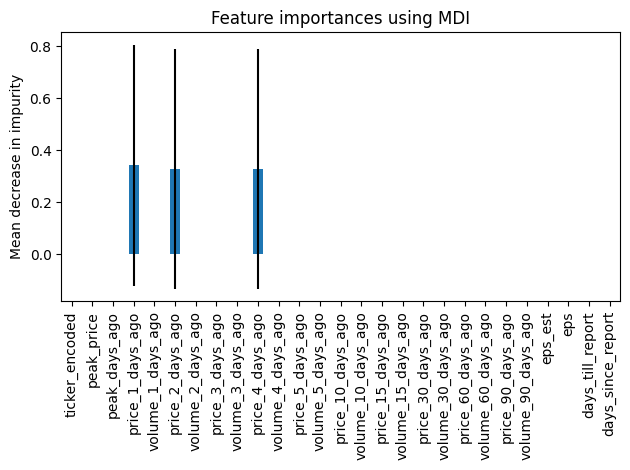

In [126]:
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

importances = model.feature_importances_
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()